In [177]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from PIL import Image
import os
import glob
import tensorflow as tf
from tensorflow.keras.models import Sequential
from keras.layers.convolutional import Conv2D
from tensorflow.keras.layers import MaxPooling2D, Dense, Flatten, Dropout

In [178]:
import zipfile
with zipfile.ZipFile('Image_classification_data.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

main_data = pd.read_csv('data_labels_mainData.csv')
extra_data = pd.read_csv('data_labels_extraData.csv')
# Specify the folder path where the images are located
folder_path = './patch_images/'

# Use glob to get a list of image file paths
image_paths = glob.glob(folder_path + '/*.png')  # Change the extension as per your image file types
df_paths = pd.DataFrame({'Image_Path': image_paths})

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)


df_paths['ImageName'] = df_paths['Image_Path'].apply(lambda x: os.path.basename(x))
data_merged_main  = pd.merge(main_data,df_paths, on='ImageName',how='inner')
data_merged_extra = pd.merge(extra_data,df_paths, on='ImageName',how='inner')

# train_data
data_merged_extra 


,InstanceID,patientID,ImageName,isCancerous,Image_Path
0,12681,61,12681.png,0,./patch_images/12681.png
1,12682,61,12682.png,0,./patch_images/12682.png
2,12683,61,12683.png,0,./patch_images/12683.png
3,12684,61,12684.png,0,./patch_images/12684.png
4,12685,61,12685.png,0,./patch_images/12685.png
...,...,...,...,...,...
10379,20028,99,20028.png,0,./patch_images/20028.png
10380,20029,99,20029.png,0,./patch_images/20029.png
10381,20030,99,20030.png,0,./patch_images/20030.png
10382,20031,99,20031.png,0,./patch_images/20031.png


In [179]:
train_data, test_data = train_test_split(data_merged_main , test_size=0.2, random_state=0)
train_data, val_data = train_test_split(train_data , test_size=0.25, random_state=0)

# train_data, test_data = train_test_split(train_data2, test_size=0.2, random_state=0)
# train_data, val_data = train_test_split(train_data2, test_size=0.25, random_state=0)

print("Train data : {}, Val Data: {}, Test Data: {}".format(train_data.shape[0], val_data.shape[0], test_data.shape[0]))

Train data : 5937, Val Data: 1979, Test Data: 1980


In [180]:
INPUT_DIM = (27,27,3)
HIDDEN_LAYER_DIM = 256
OUTPUT_CLASSES = 4

In [181]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
model = Sequential([
    # Convolutional layers
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=INPUT_DIM),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    # Flatten the output
    tf.keras.layers.Flatten(),

    # Dense layers
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4, activation='softmax')
])


model.summary()

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)  # Adjust the learning rate if needed

model.compile(optimizer=optimizer,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

early_stopping = EarlyStopping(patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=5)

# Increase the number of training epochs
epochs = 50

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
# val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)
val_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./',
        x_col="Image_Path",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./',
        x_col="Image_Path",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

test_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./',
        x_col="Image_Path",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

history = model.fit(
    train_generator,
    steps_per_epoch=len(train_data) // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=len(val_data) // batch_size,
    callbacks=[early_stopping, reduce_lr]
)




Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 25, 25, 32)        896       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 12, 12, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 10, 10, 64)        18496     
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 5, 5, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 3, 3, 128)         73856     
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 1, 1, 128)      

TypeError: If class_mode="categorical", y_col="cellType" column values must be type string, list or tuple.

In [ ]:

train_loss, train_accuracy = model.evaluate(train_generator, verbose=0)
print('Train Loss:', train_loss)
print('Train Accuracy:', train_accuracy)

# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(validation_generator, verbose=0)
print('Validation Loss:', val_loss)
print('Validation Accuracy:', val_accuracy)


test_loss, test_accuracy = model.evaluate(test_generator, verbose=0)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)


2023-05-16 04:28:05.038574: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Train Loss: 0.5885626673698425
Train Accuracy: 0.7705911993980408


2023-05-16 04:28:10.160729: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Validation Loss: 0.5754151344299316
Validation Accuracy: 0.7721071243286133


2023-05-16 04:28:11.518571: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Test Loss: 0.5879330635070801
Test Accuracy: 0.7791814208030701


In [ ]:
INPUT_DIM = (27,27,3)
HIDDEN_LAYER_DIM = 256
OUTPUT_CLASSES = 4

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'),
    tf.keras.layers.Dense(OUTPUT_CLASSES)
])

model.summary()

model.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_14 (Flatten)        (None, 2187)              0         
                                                                 
 dense_40 (Dense)            (None, 256)               560128    
                                                                 
 dense_41 (Dense)            (None, 256)               65792     
                                                                 
 dense_42 (Dense)            (None, 4)                 1028      
                                                                 
Total params: 626,948
Trainable params: 626,948
Non-trainable params: 0
_________________________________________________________________


In [ ]:
train_data['cellType'] = train_data['cellType'].astype(str)
val_data['cellType'] = val_data['cellType'].astype(str)
test_data['cellType'] = test_data['cellType'].astype(str)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./',
        x_col="Image_Path",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./',
        x_col="Image_Path",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 5937 validated image filenames belonging to 4 classes.
Found 1979 validated image filenames belonging to 4 classes.


In [ ]:
history = model.fit_generator(train_generator, validation_data = validation_generator, epochs=50, verbose=0)

/var/folders/6y/3ldd75pj46v0c4qyh730qx400000gn/T/ipykernel_5113/2779164914.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, validation_data = validation_generator, epochs=50, verbose=0)
2023-05-16 00:58:27.971841: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-16 00:58:30.995297: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


In [ ]:
import matplotlib.pyplot as plt
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()

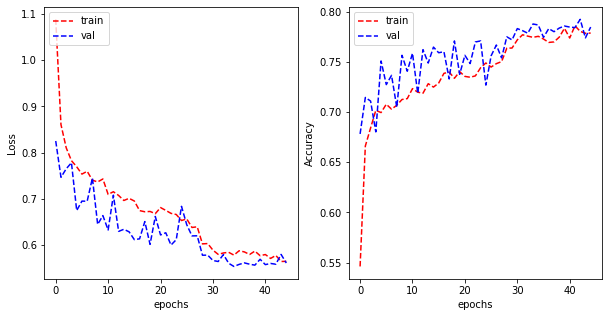

  5/186 [..............................] - ETA: 4s - loss: 0.4775 - categorical_accuracy: 0.8188

2023-05-16 03:40:14.631871: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


186/186 [==============================] - 4s 22ms/step - loss: 0.5643 - categorical_accuracy: 0.7807


[0.564262866973877, 0.7806973457336426]

In [ ]:
plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

model.evaluate(train_generator)

In [ ]:
model.save("cellType")

2023-05-16 03:40:32.227879: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]
2023-05-16 03:40:32.490287: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: cellType/assets


INFO:tensorflow:Assets written to: cellType/assets


In [ ]:
#test Data
test_data['isCancerous'] = test_data['isCancerous'].astype('str')

test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 1

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data,
        directory='./',
        x_col="Image_Path",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

model.evaluate(test_generator)

Found 1980 validated image filenames belonging to 4 classes.
  41/1980 [..............................] - ETA: 2s - loss: 1.0663 - categorical_accuracy: 0.5366  

2023-05-16 01:01:05.694597: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1980/1980 [==============================] - 3s 1ms/step - loss: 0.8071 - categorical_accuracy: 0.6889


[0.8070784211158752, 0.6888889074325562]

In [ ]:
label_names = {'fibroblast' : 0, 'inflammatory' : 1, 'epithelial' : 2, 'others' : 3}

TypeError: Invalid shape (32, 27, 27, 3) for image data

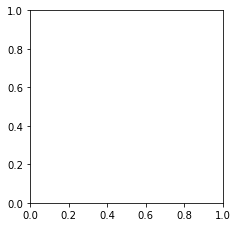

In [ ]:
d_inv = {v: k for k, v in label_names.items()}
plt.figure(figsize=(20,7))
batches = 0
for x,y in test_generator:
        batches = batches + 1
        y_hat = model.predict(x, verbose=0)
        x = np.squeeze(x)
        if batches < 5:
            plt.subplot(1,5,batches)
            plt.imshow(x)
            plt.title("GT-{}, Pred-{}".format(d_inv[np.argmax(y[0])], d_inv[np.argmax(y_hat[0])] ))
            
        else:
            break
        
        plt.axis('off')

In [ ]:

#unseen data
test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

unseenData_generator = test_datagen.flow_from_dataframe(
        dataframe=data_merged_extra,#change this line
        directory='./',
        x_col="Image_Path",
        y_col=None,#we are predicting this  
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode=None)#predicting this thats the diffrence from train data

# Load the trained model
model = tf.keras.models.load_model('cellType')#this line 

# Make predictions on the unseen data
predictions = model.predict(unseenData_generator)


# Process the predictions
predicted_classes = np.argmax(predictions, axis=1)
class_labels = train_generator.class_indices


Found 10384 validated image filenames.
  6/325 [..............................] - ETA: 3s 

2023-05-16 03:41:09.496195: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


325/325 [==============================] - 4s 12ms/step


In [ ]:
label_names = {'fibroblast' : 0, 'inflammatory' : 1, 'epithelial' : 2, 'others' : 3}
reversed_label_names = {v: k for k, v in label_names.items()}

predicted_labels = [reversed_label_names[class_index] for class_index in predicted_classes]


image_filenames = unseenData_generator.filenames


results_df = pd.DataFrame({'Image_Path': image_filenames, 'Predicted_type': predicted_classes, 'Predicted_type_name': predicted_labels})


print(results_df)

results_df.to_csv('unseen_results.csv', index=False)

                     Image_Path  Predicted_type Predicted_type_name
0      ./patch_images/12681.png               2          epithelial
1      ./patch_images/12682.png               2          epithelial
2      ./patch_images/12683.png               1        inflammatory
3      ./patch_images/12684.png               2          epithelial
4      ./patch_images/12685.png               2          epithelial
...                         ...             ...                 ...
10379  ./patch_images/20028.png               1        inflammatory
10380  ./patch_images/20029.png               2          epithelial
10381  ./patch_images/20030.png               2          epithelial
10382  ./patch_images/20031.png               2          epithelial
10383  ./patch_images/20032.png               2          epithelial

[10384 rows x 3 columns]


In [ ]:
# # Increase the number of epochs
# model = tf.keras.Sequential([
#     tf.keras.layers.Flatten(input_shape=INPUT_DIM),
#     tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='relu'),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='relu'),  # Add an additional hidden layer
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Dense(OUTPUT_CLASSES)
# ])
# # Compile the model
# model.compile(optimizer='adam',  # Change the optimizer to Adam for better convergence
#               loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])  # Use 'accuracy' instead of 'categorical_accuracy'

# # Train the model
# history = model.fit(train_generator, validation_data=validation_generator, epochs=200, verbose=0)

# # Plot the learning curves
# plot_learning_curve(history.history['loss'], history.history['val_loss'], 
#                     history.history['accuracy'], history.history['val_accuracy'], 
#                     metric_name='Accuracy')

# # Evaluate the model
# model.evaluate(test_generator)

# # Print the model summary
# model.summary()

In [ ]:
# model_VGG_1 = tf.keras.Sequential([
#     #VGG block 1
#     tf.keras.layers.Conv2D(27, (3, 3), activation='relu', padding='same', input_shape=(27, 27, 3)),
#     tf.keras.layers.Conv2D(27, (3, 3), activation='relu', padding='same'),
#     tf.keras.layers.MaxPooling2D((2, 2)),
    
#     #VGG block 2
#     tf.keras.layers.Conv2D(54, (3, 3), activation='relu', padding='same'),
#     tf.keras.layers.Conv2D(54, (3, 3), activation='relu', padding='same'),
#     tf.keras.layers.MaxPooling2D((2, 2)),
    
#     #VGG block 3
#     tf.keras.layers.Conv2D(108, (3, 3), activation='relu', padding='same'),
#     tf.keras.layers.Conv2D(108, (3, 3), activation='relu', padding='same'),
#     tf.keras.layers.MaxPooling2D((2, 2)),
    
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(108, activation='relu'),
#     tf.keras.layers.Dense(OUTPUT_CLASSES),
# ])
# model_VGG_1.compile(optimizer='adam',
#               loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
#               metrics=['categorical_accuracy'])

# history_VGG_1 = model_VGG_1.fit_generator(train_generator, validation_data = validation_generator, epochs=25, verbose=0)

# plot_learning_curve(history_VGG_1.history['loss'], history_VGG_1.history['val_loss'], 
#                     history_VGG_1.history['categorical_accuracy'], history_VGG_1.history['val_categorical_accuracy'], 
#                     metric_name='Accuracy')


